In [1]:
from sentinelhub import SHConfig

INSTANCE_ID = ''  # In case you put instance ID into configuration file you can leave this unchanged

if INSTANCE_ID:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
else:
    config = None
    
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import datetime
import numpy as np
from datetime import datetime, timedelta


from sentinelhub import BBox, CRS

import matplotlib.pyplot as plt
from pyproj import Transformer
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox
def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)
        
def get_image(coords_wgs84, size, history_search,date):
    date_string = date.strftime("%d-%m-%Y")
    box_k=180/size[1];
    bbox = BBox(bbox=[coords_wgs84[0],
                      coords_wgs84[1],
                      coords_wgs84[2],
                      coords_wgs84[3]+(coords_wgs84[3]-coords_wgs84[1])*box_k], crs=CRS.WGS84)
    wms_request = WmsRequest(
        layer='TRUE_COLOR',
        bbox=bbox,
        time=date_string,
        width=size[0],
        height=size[1]+180,
        config=config
    )
    wms_img = wms_request.get_data()
    if len(wms_img) == 0 and history_search>0:
        return get_image(coords_wgs84,size, history_search-1,date - timedelta(days=1))
    wms_img=wms_img[-1]
    return wms_img[:][:size[1]]

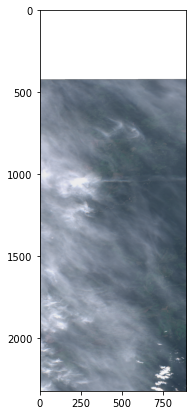

In [2]:
#Кусок с примером работы. Надо, чтобы размер выходных данных не превышал 2320 по высоте.

coords_wgs84 = [56.571539641228455,54.18006117266345,56.94362428922989,55.145947983133794]


size_k=(coords_wgs84[2]-coords_wgs84[0])/(coords_wgs84[3]-coords_wgs84[1])
size_value=2320
if size_k<1:
    size=(int(size_value*size_k),int(size_value))
else:
    size=(int(size_value),int(size_value/size_k))

#Координаты, размер результата, количество просматриваемых дней истории, с какой даты начать
plot_image(get_image(coords_wgs84,size,14,datetime.today() - timedelta(days=0)))

In [3]:
import json
with open("polygons.json", "r") as fin:
    polygons = json.loads(fin.readline())

[490491.28170000017, 6220139.663699999] [491455.7536000004, 6221792.3006]


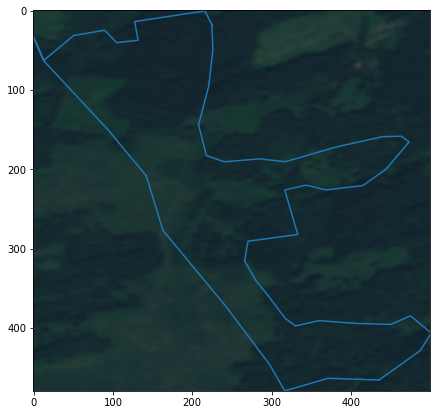

In [37]:

def proj(x1,y1):
    #inProj = Proj('epsg:32640')
    #outProj = Proj('epsg:4326')
    transformer = Transformer.from_crs("epsg:32640", "epsg:4326")
    x2,y2=transformer.transform(x1, y1)
    return x2,y2

import shapefile

sf = shapefile.Reader("fields.dbf")
features = sf.shapeRecords()

feature =features[1]

first = feature.shape.__geo_interface__  
poly_coords=first["coordinates"][0]
p1=[9999999999,99999999999]
p2=[0,0]
for point in poly_coords:
    if point[0]<p1[0]:
        p1[0]=point[0]
    if point[1]<p1[1]:
        p1[1]=point[1]
    if point[0]>p2[0]:
        p2[0]=point[0]
    if point[1]>p2[1]:
        p2[1]=point[1]
print(p1,p2)
p1=proj(p1[0],p1[1])
p2=proj(p2[0],p2[1])
coords_wgs84 = [p1[1],p1[0]-0.0015,p2[1],p2[0]-0.0015]

coords_new=[]
for point in poly_coords:
    coords_new.append(proj(point[0],point[1]))
    
    


size_k=(coords_wgs84[2]-coords_wgs84[0])/(coords_wgs84[3]-coords_wgs84[1])
size_value=500
if size_k<1:
    size=(int(size_value*size_k),int(size_value))
else:
    size=(int(size_value),int(size_value/size_k))



coords_relative=[]
for point in coords_new:
    coords_relative.append(((point[1]-p1[1])/(p2[1]-p1[1])*size[0],(p2[0]-point[0])/(p2[0]-p1[0])*size[1]))
    
xs=[]
ys=[]
for point in coords_relative:
    xs.append(point[0])
    ys.append(point[1])
    
image=(get_image(coords_wgs84,size,20,datetime.today() - timedelta(days=85)))


fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

ax.plot(xs,ys) 
if np.issubdtype(image.dtype, np.floating):
    plt.imshow(np.minimum(image * factor, 1))
else:
    plt.imshow(image)
plt.show()


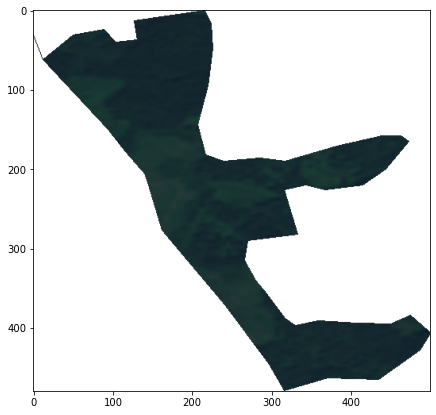

In [41]:
import cv2
mask = np.zeros((size[1], size[0]), dtype=np.uint8)
pts = np.array(coords_relative, dtype=np.int32)
cv2.fillPoly(mask, np.int32([pts]), 255)
masked = cv2.bitwise_and(image,image,mask = mask)
plot_image(masked)